In [ ]:
# Function to calculate the cost (time) of trucks traveling from point s to point t
def t_cost(s, t):
    return ((s[0] - t[0])**2 + (s[1] - t[1])**2)**(0.5)

# Function to calculate the cost (time) of drones traveling from point s to point t with a scaling factor alpha
def d_cost(s, t, alpha):
    return (1/alpha) * (((s[0] - t[0])**2 + (s[1] - t[1])**2)**(0.5))

# Function to calculate the path cost (time) of trucks on a given route segment [a, b) using locations in V
def t_pathcost(a, b, route, V):
    pathcost = 0

    # Traverse the route segment [a, b) and accumulate truck travel costs
    if a < b:
        for i in range(a, b):
            pathcost += t_cost(V[route[i]], V[route[(i + 1) % len(route)]])
    elif a > b:
        for i in range(a, len(route)):
            pathcost += t_cost(V[route[i]], V[route[(i + 1) % len(route)]])
        for i in range(b):
            pathcost += t_cost(V[route[i]], V[route[(i + 1) % len(route)]])
    elif a == b:
        # If a and b are the same, the path cost is zero
        pathcost = 0

    return pathcost


In [ ]:
import random
import math
import numpy

# Set a seed for random number generation to ensure reproducibility
random.seed(0)

# Function to generate a test case where customers are located uniformly
def testcase_uniform(n):
    # Create a list of n customer locations with random x and y coordinates between 0 and 100
    V = [(random.uniform(0, 100), random.uniform(0, 100)) for i in range(n)]
    return V

# Function to generate a test case where customers are located in the shape of a donut
def testcase_donuts(n):
    V = []
    # Generate n customer locations in the shape of a donut around the center (50, 50)
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        V.append((25 * random.uniform(0.9, 1.1) * math.cos(angle) + 50,
                  25 * random.uniform(0.9, 1.1) * math.sin(angle) + 50))
    return V

# Function to generate a test case where customers are located in the shape of a donut, but the depot is in the center
def testcase_donuts_center(n):
    # Initialize the list with the depot location at the center (50, 50)
    V = [(50, 50)]
    # Generate (n-1) customer locations in the shape of a donut around the center
    for i in range(n-1):
        angle = random.uniform(0, 2*math.pi)
        V.append((25 * random.uniform(0.9, 1.1) * math.cos(angle) + 50,
                  25 * random.uniform(0.9, 1.1) * math.sin(angle) + 50))
    return V

# Function to generate a test case where customers are located more in the center but less on the outskirts
def testcase_center(n):
    V = []
    # Generate n customer locations with coordinates based on a normal distribution around the center (50, 50)
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        r = numpy.random.normal(0, 25)
        V.append((r * math.cos(angle) + 50, r * math.sin(angle) + 50))
    return V


In [ ]:
import heapq
from basic_functions import t_cost
import itertools

## These algorithms return the routes

# 2-approximation algorithm using a minimum spanning tree
def two_approximation_for_TSP(V):
    n = len(V)
    # Prim's algorithm to find the minimum spanning tree (MST)
    mst = {i: [] for i in range(n)}  # MST's adjacency list
    X = set()
    heap = []

    # Initialize the heap with edges from the first vertex (0) to other vertices
    for i in range(1, n):
        heapq.heappush(heap, (t_cost(V[0], V[i]), 0, i))

    while len(heap) > 0:
        (d, u, i) = heapq.heappop(heap)
        if i not in X:
            X.add(i)
            mst[u].append(i)
            mst[i].append(u)
            for w in range(n):
                if w not in X:
                    heapq.heappush(heap, (t_cost(V[i], V[w]), i, w))

    # Depth-first search to construct the route from the MST
    res = []
    stack = [0]
    visited = [False] * n

    while len(stack) > 0:
        i = stack.pop()
        if visited[i]:
            continue
        visited[i] = True
        res.append(i)
        for u in mst[i]:
            stack.append(u)

    return res

# 2-opt algorithm using edge swaps
def two_opt_for_TSP(V):
    n = len(V)
    res = list(range(n))
    update = True

    while update:
        update = False
        for (i, j) in itertools.combinations(range(n), 2):
            if (t_cost(V[res[i]], V[res[i + 1]]) + t_cost(V[res[j]], V[res[(j + 1) % n]]) >
                    t_cost(V[res[i]], V[res[j]]) + t_cost(V[res[i + 1]], V[res[(j + 1) % n]])):
                res[i + 1:j + 1] = res[j:i:-1]
                update = True

    return res

# Dynamic programming algorithm
def DP_for_TSP(V):
    length = {}  # length[(u, S)]: Minimum route length starting from u and visiting all points in set S, dictionary
    route = {}   # route[(u, S)]: Route to achieve the minimum route length, dictionary
    v = V[0]
    n = len(V)

    # Iterate over all possible combinations of points to compute the minimum route length and route
    for i in range(1, n + 1):
        for a in itertools.combinations(range(n), i):
            S = frozenset(a)

            for j in S:
                u = V[j]

                if i == 1:
                    length[(j, S)] = t_cost(v, u)
                    route[(j, S)] = [j]
                else:
                    Sj = S - set([j])  # S without j
                    k = min(Sj, key=lambda k: length[(k, Sj)] + t_cost(V[k], u))
                    length[(j, S)] = length[(k, Sj)] + t_cost(V[k], u)
                    route[(j, S)] = route[(k, Sj)] + [j]

    return route[(0, frozenset(range(n)))]


------------------------------------------------------------------------------------------------------------------------------------------------
Running time of DP for TSP-D: 2.8521 sec

Total cost (time) to deliver all customers: 87.4431

Cities Traveled in Sequence:
Segment 1: (Truck --> City 0) 
Segment 2: (Truck --> City 5) (Drone --> City 1) 
Segment 3: (Truck --> City 6) (Drone --> City 8) 
Segment 4: (Truck --> City 3) (Drone --> City 7) 
Segment 5: (Truck --> City 4) (Truck --> City 0) (Drone --> City 2) 



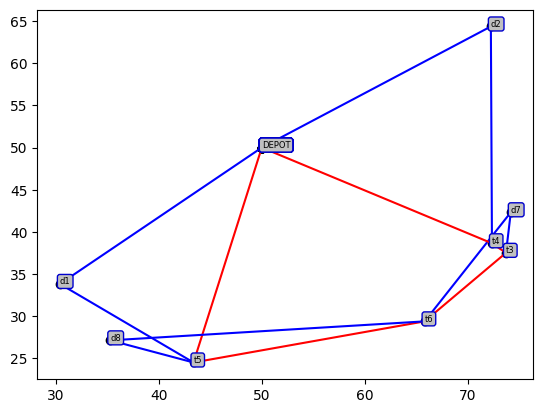


Calculated total cost: 205.3805
------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
from generating_functions import *
from route_drawing import *
from basic_functions import t_cost, d_cost
import itertools
import time

def DP_for_TSPD(V, depot, alpha):
    """
    Solves the Traveling Salesman Problem with Drones (TSP-D) using Dynamic Programming.

    Parameters taken:
    - V: List of customer coordinates.
    - depot: Index of the depot (truck and drone starting and ending point).
    - alpha: Speed ratio between the truck and drone.

    Returns:
    - total_cost: Minimum total time to deliver all customers.
    - route: Optimal delivery route for both truck and drone.
    - drone_nodes: Set of drone nodes used in the solution.
    """
    n = len(V) #get no. of nodes from user

    # Dt: Minimum truck route cost dictionary from (S, v, w)
    # truck: Truck route dictionary for each case (S, v, w)
    Dt = {}  # For truck routes
    truck = {}

    # Initialize Dt and truck for cases with a single customer
    for i in range(1, n + 1):
        for a in itertools.combinations(range(n), i):
            S = frozenset(a)
            for v in range(n):
                for w in S:
                    Dt[(S, v, w)] = float('inf')
                    if i == 1:
                        Dt[(S, v, w)] = t_cost(V[v], V[w])
                        truck[(S, v, w)] = [w]
                    else:
                        Sw = S - set([w])
                        for u in Sw:
                            z = Dt[(Sw, v, u)] + t_cost(V[u], V[w])
                            p = truck[(Sw, v, u)] + [w]
                            if z < Dt[(S, v, w)]:
                                Dt[(S, v, w)] = z
                                truck[(S, v, w)] = p

    # Dop: Minimum total cost (truck and drone) dictionary from (S, v, w)
    # operation: Sequence of operations dictionary for each case (S, v, w)
    Dop = {} # For combined truck and drone routes
    operation = {}

    # Initialize Dop and operation for cases with a single customer
    for i in range(1, n + 1):
        for a in itertools.combinations(range(n), i):
            S = frozenset(a)
            for v in range(n):
                for w in S:
                    Dop[(S, v, w)] = Dt[(S, v, w)]
                    operation[(S, v, w)] = truck[(S, v, w)]
                    if i == 1:
                        Dop[(S, v, w)] = Dt[(S, v, w)]
                        operation[(S, v, w)] = truck[(S, v, w)]
                    else:
                        Svw = S - set([v]) - set([w])
                        for d in Svw:
                            drone_cost = d_cost(V[v], V[d], alpha) + d_cost(V[d], V[w], alpha)
                            Sd = S - set([d])
                            z = max(drone_cost, Dt[(Sd, v, w)])
                            if z < Dop[(S, v, w)]:
                                Dop[(S, v, w)] = z
                                operation[(S, v, w)] = truck[(Sd, v, w)] + [[d]]

    # D: Minimum total cost and route dictionary from (S, w)
    # route: Route dictionary for each case (S, w)
    D = {} # For final solution
    route = {}

    # Initialize D and route for cases with a single customer #Step1: Truck Routes
    for i in range(1, n + 1):
        for a in itertools.combinations(range(n), i):
            S = frozenset(a)
            for w in S:
                D[(S, w)] = float('inf')

    for i in range(n):
        D[(frozenset({i}), i)] = Dop[(frozenset({i}), depot, i)]
        route[(frozenset({i}), i)] = [operation[(frozenset({i}), depot, i)]]

    # Iterate over all possible combinations of customers and their subsets #Step2: Combined Truck and Drone Routes
    for i in range(1, n + 1):
        for a in itertools.combinations(range(n), i):
            U = set(a)
            T = set(range(n)) - U
            for j in range(1, len(T) + 1):
                for b in itertools.combinations(T, j):
                    Tset = set(b)
                    for u in U:
                        for w in range(n):
                            z = D[(frozenset(U), u)] + Dop[(frozenset(Tset | {w}), u, w)]
                            p = route[(frozenset(U), u)] + [operation[(frozenset(Tset | {w}), u, w)]]
                            if z < D[(frozenset(U | Tset | {u, w}), w)]:
                                D[(frozenset(U | Tset | {u, w}), w)] = z
                                route[(frozenset(U | Tset | {u, w}), w)] = p

    # Extract the final route, total cost, and set of drone nodes # Step 3: Final Solution
    path = route[(frozenset(range(n)), depot)]
    drone_nodes = set()

    for i in range(len(path)):
        if type(path[i][-1]) == list:
            drone_nodes.add(path[i][-1][0])

    total_cost = D[(frozenset(range(n)), depot)]

    return total_cost, path, drone_nodes

# Function to print nodes in sequence for a given route
def print_nodes_in_sequence(path):
    print("Cities Traveled in Sequence:")
    for i, segment in enumerate(path):
        print(f"Segment {i + 1}:", end=" ")
        for node in segment:
            if isinstance(node, list):
                print(f"(Drone --> City {node[0]})", end=" ")
            else:
                print(f"(Truck --> City {node})", end=" ")
        print()

def calculate_total_cost(V, route, alpha):
    total_cost = 0

    for segment in route:
        for node in segment:
            if isinstance(node, list):  # Drone operation
                drone_city = node[0]
                total_cost += d_cost(V[drone_city - 1], V[drone_city], alpha)
            else:  # Truck operation
                truck_city = node
                total_cost += t_cost(V[truck_city - 1], V[truck_city])

    return total_cost

def main():
    n = 1  # Add the no. of cities from here
    V = testcase_donuts_center(n)  # Arrange how you want to arrange cities from here
    alpha = 2  # Factor of efficiency of Drone over Truck

    start = time.time()
    total_cost, route, drone_nodes = DP_for_TSPD(V, 0, alpha)
    end = time.time()

    print("------------------------------------------------------------------------------------------------------------------------------------------------")
    print(f"Running time of DP for TSP-D: {round(end - start, 4)} sec")
    print()
    print(f"Total cost (time) to deliver all customers: {round(total_cost, 4)}")
    print()
    print_nodes_in_sequence(route)
    print()
    drawing_routes_for_DP(V, route, 0, drone_nodes)
    print()
    # Calculate and print the cost
    calculated_cost = calculate_total_cost(V, route, alpha)
    print(f"Calculated total cost: {round(calculated_cost, 4)}")

    print("------------------------------------------------------------------------------------------------------------------------------------------------")

if __name__ == '__main__':
    main()

